In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd drive/MyDrive/ML DL

/content/drive/MyDrive/ML DL


In [ ]:
import warnings
warnings.filterwarnings('ignore')

# 생성적 적대 신경망(Generate Adversarial Network, GAN)

* 생성자(Generator)와 판별자(Discriminator)라는 두 개의 신경망이 경쟁적으로 학습하는 과정을 통해 데이터셋의 분포를 학습하고 새로운 데이터를 생성하는 모델

* 데이터를 생성하므로 라벨이 필요없는 비지도 학습

* 생성자 네트워크는 판별자 네트워트를 속일 수 있도록 학습한다.
  - 생성자 네트워크(Generator Network): 무작위로 생성된 랜덤 벡터를 입력받아 학습 데이터셋과 유사한 형태로 변환한다. -> 실제를 모방하는 것
  - 판별자 네트워크(Discriminator Network): 데이터를 입력받아 학습 데이터셋에서 온 진짜 데이터인지, 생성자 네트워크가 만든 가짜 데이터인지 판별한다.

* 학습이 계속될수록 생성자는 판별자를 속이기 위하여 더욱 더 진짜같은 가짜 데이터를 만들게 되고, 판별자는 진짜와 가짜를 구분하기 위해서 더 정교해진다.<br>
  -> 생성자는 점차 실제 데이터와 구별하기 힘든 가짜 데이터를 만들 수 있게 된다.
* 하지만 다른 딥러닝 네트워크처럼 손실 최소화만으로 최적화가 이뤄지지 않으며, 생성자와 판별자 간의 밸런스가 동적으로 고려되어야 한다.<br>
  -> 학습과 튜닝이 매우 어려움

* 대표적인 문제로 모드 붕괴(model collapse)가 있다.
  - 생성자가 데이터의 전체 다양성을 반영하지 못하고 일부 특정 패턴에만 집중하여 데이터를 생성하는 현상(판별자가 너무 강하게 학습되어 생성자가 판별자를 속이기 위해 측정 패턴에만 집중하는 상황 등에서 발생한다.)

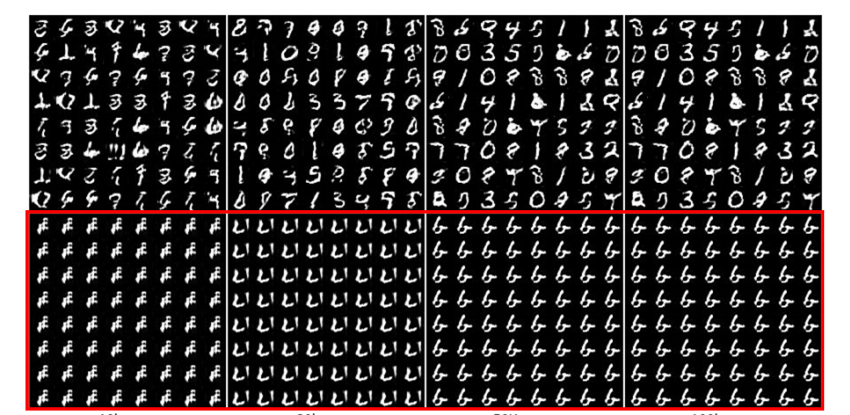
* 이를 해결하고 안정적으로 GAN을 사용하기 위한 연구가 계속되고 있다.

## 데이터셋 준비하기

### celebA 데이터 다운로드

In [ ]:
# celeba_gan 폴더 생성
!mkdir celeba_gan
# GAN 모델 학습 시 epoch마다 생성자가 생성하는 이미지를 저장하는 폴더 생성
!mkdir celeba_gan_output
# celeba_gan 폴더 내 data.zip으로 파일 다운로드
!wget "https://drive.google.com/uc?id=1up5bN8LCE2vHigVY-Z9yY2_aKRW5jN_9&confirm=t" -O celeba_gan/data.zip
# 파일 압축 해제
!unzip -qq celeba_gan/data.zip -d celeba_gan

--2023-04-28 06:07:45--  https://drive.google.com/uc?id=1up5bN8LCE2vHigVY-Z9yY2_aKRW5jN_9&confirm=t
Resolving drive.google.com (drive.google.com)... 74.125.24.138, 74.125.24.101, 74.125.24.100, ...
Connecting to drive.google.com (drive.google.com)|74.125.24.138|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-04-a4-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/h76ksttvmqr36ajk203ecp7ljove5l8b/1682662050000/10613826186492816817/*/1up5bN8LCE2vHigVY-Z9yY2_aKRW5jN_9?uuid=08482afb-c4a3-4b45-a18f-d235925eec14 [following]
--2023-04-28 06:07:45--  https://doc-04-a4-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/h76ksttvmqr36ajk203ecp7ljove5l8b/1682662050000/10613826186492816817/*/1up5bN8LCE2vHigVY-Z9yY2_aKRW5jN_9?uuid=08482afb-c4a3-4b45-a18f-d235925eec14
Resolving doc-04-a4-docs.googleusercontent.com (doc-04-a4-docs.googleusercontent.com)... 142.251.12.132, 2404:6800:4003:c11::84
Connecting to 

### 이미지 디렉토리에서 데이터셋 생성

In [13]:
from tensorflow import keras
# image_dataset_from_directory() 메소드를 사용한 데이터 로드
dataset = keras.utils.image_dataset_from_directory(
    "celeba_gan",    # 이미지 데이터셋이 포함된 디렉토리 경로
    label_mode=None,    # 라벨 없음(GAN은 비지도 학습이므로 라벨이 필요하지 않음)
    image_size=(64, 64),    # 로드할 이미지 크기를 지정
    batch_size=32,    # 배치 크기 설정
    smart_resize=True)    # 이미지를 대상 크기로 조절할 때 비율을 유지하면서 크기를 변경하고, 누락된 영역을 채우는 스마트 리사이징 기능을 활성화

Found 202599 files belonging to 1 classes.


### 픽셀 값 범위 바꾸기

In [14]:
# 배치 형태 확인
for v in dataset:
    print(v.shape)
    break

(32, 64, 64, 3)


In [15]:
# /255를 통해 모든 픽셀값을 0에서 1사이로 스케일링
dataset = dataset.map(lambda x: x / 255.)

### 첫 번째 이미지 출력하기

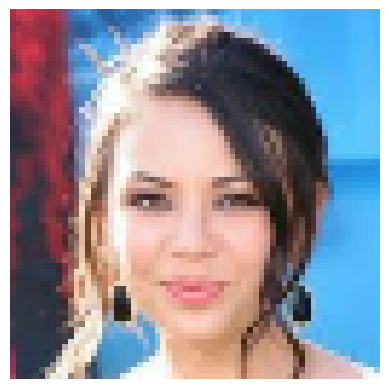

In [16]:
import matplotlib.pyplot as plt
# dataset은 tensorflow에서 사용하는 _MapDataset 타입의 데이터로 조회할 때마다 랜덤 배치 설정
# 따라서 아래 사진은 코드를 실행할 때마다 달라진다
for x in dataset:
    # 축 제거
    plt.axis('off')
    # x.numpy() * 255: 이미지 출력을 위해 스케일링한 픽셀값을 다시 되돌린다
    # [0]: 이미지 출력을 위하여 (높이, 너비, 채널)만 추출
    plt.imshow((x.numpy() * 255).astype('int32')[0])
    break

## 판별자 네트워크 생성

### GAN 판별자 네트워크

In [17]:
from keras import layers
# Sequential 클래스를 사용하여 모델 생성
discriminator = keras.Sequential(
    [
        keras.Input(shape=(64, 64, 3)),    # 입력 레이어(높이 64, 너비 64, 3채널)
        # Convnet 레이어
        layers.Conv2D(64, kernel_size=4, strides=2, padding="same"),
        # GAN은 ReLU가 아닌, LeakyReLU를 사용하는 것이 유리
        # ReLU는 max(0, x)로 x가 음수인 경우엔 모두 0이 되므로 
        # 역전파 알고리즘 수행 시 input이 음수인 뉴런의 기울기도 0이 되므로 비활성화되는데, 이러한 현상을 '희소한 그래디언트'라고 함.
        # 희소한 그래디언트가 언제나 나쁜것은 아니지만 GAN에 있어서는 학습을 방해할 수 있음
        # 따라서 이를 완화하기 위하여 LeakyReLU 사용
     
        # 활성화함수 레이어; alpha=음수 입력값에 대하여 곱해지는 수
        layers.LeakyReLU(alpha=0.2),
        # Convnet 레이어
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        # 활성화함수 레이어
        layers.LeakyReLU(alpha=0.2),
        # Convnet 레이어
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        # 활성화함수 레이어
        layers.LeakyReLU(alpha=0.2),
        # 평탄화 레이어
        layers.Flatten(),
        # GAN 모델에 있어서 드롭아웃은 과적합 방지의 의미도 있지만 모델에 무작위성을 부여함으로써(코드의 경우 무작위로 20%의 뉴런이 드롭아웃됨) 모델을 더욱 견고하게 만듬
        # 드롭아웃 레이어
        layers.Dropout(0.2),
        # 판별자는 진짜/가짜의 이진분류를 수행하므로 sigmoid 사용
        layers.Dense(1, activation="sigmoid"),
    ],
    name="discriminator",    # 모델 이름 정의
)

In [18]:
# 모델 요약
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 64)        3136      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 128)       131200    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 128)         262272    
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 8, 8, 128)         0         
                                                                 
 flatten (Flatten)           (None, 8192)            

## 생성자 네트워크 생성

### GAN 생성자 네트워크

In [19]:
# 생성자는 잠재공간(latent space)에서 벡터를 입력받아 이미지를 생성
# 잠재공간의 차원 정의(128차원)
latent_dim = 128
# Sequential 클래스를 사용하여 모델 생성
generator = keras.Sequential(
    [
        # 입력 레이어(128 크기의 벡터)
        keras.Input(shape=(latent_dim,)),
        # 완전 연결 레이어를 통해 8 * 8 * 128 = 8192크기의 벡터로 변환
        layers.Dense(8 * 8 * 128),
        # 크기를 확대한 벡터를 (8, 8, 128) 형태의 3차원 텐서로 변환
        layers.Reshape((8, 8, 128)),
        # 전치합성곱을 사용한 업샘플링(이미지 해상도 증가)
        layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same"),
        # 활성화함수 레이어
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(256, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(512, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        # 출력 이미지의 크기를 유지하기 위하여 패딩 적용
        # 출력 이미지의 픽셀값을 0에서 1사이로 고정하기 위하여 sigmoid 함수 사용
        # 출력 레이어
        layers.Conv2D(3, kernel_size=5, padding="same", activation="sigmoid"),
    ],
    name="generator",    # 모델 이름 정의
)

In [20]:
# 모델 요약
generator.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 8192)              1056768   
                                                                 
 reshape (Reshape)           (None, 8, 8, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 16, 16, 128)      262272    
 nspose)                                                         
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 32, 32, 256)      524544    
 ranspose)                                                       
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 32, 32, 256)       0 

## 적대 네트워크 생성

### GAN 모델

In [21]:
import tensorflow as tf
# keras.Model 클래스를 상속한 사용자 클래스 GAN 정의
class GAN(keras.Model):
    # 생성자 정의(위의 생성자 네트워크와 다른 클래스 생성자, 혼동 주의)
    def __init__(self, discriminator, generator, latent_dim):
        # 부모 클래스 keras.Model의 생성자 호출
        super().__init__()
        # 객체 생성시 전달받은 인자를 클래스 변수에 할당
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        # 판별자 손실을 추적하는 데 사용되는 keras.metrics.Mean 객체 생성
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        # 생성자 손실을 추적하는 데 사용되는 keras.metrics.Mean 객체 생성
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        # 부모 클래스인 keras.Model의 compile 메소드 호출
        super(GAN, self).compile()
        # 인자로 전달된 판별자의 옵티마이저(d_optimizer)를 클래스 변수로 저장
        self.d_optimizer = d_optimizer
        # 인자로 전달된 생성자의 옵티마이저(g_optimizer)를 클래스 변수로 저장
        self.g_optimizer = g_optimizer
        # 인자로 전달된 손실함수(loss_fn)을 클래스 변수로 저장
        self.loss_fn = loss_fn

    # 데코레이터를 적용하여 metric 메소드를 속성처럼 사용
    @property
    # 학습 중에 추적할 metric 반환
    def metrics(self):
        # 판별자와 생산자의 손실 추적
        return [self.d_loss_metric, self.g_loss_metric]

    # 모델의 학습 루프를 설정하는 사용자 함수 작성
    def train_step(self, real_images):

        # 판별자에 전달할 데이터 생성
        # real_images의 0번째 축을 batch_size로 설정
        batch_size = tf.shape(real_images)[0]
        # 정규분포에서 (batch_size, self.latent_dim) 크기의 무작위 잠재 벡터 생성
        random_latent_vectors = tf.random.normal(
            shape=(batch_size, self.latent_dim))
        # 잠재 벡터를 사용하여 생성자로 가짜 이미지 생성
        generated_images = self.generator(random_latent_vectors)
        # 가짜 이미지와 실제 이미지를 합쳐서 하나의 텐서 생성
        combined_images = tf.concat([generated_images, real_images], axis=0)
        # 가짜 이미지의 레이블은 1로(tf.ones((batch_size, 1)), 
        # 실제 이미지에 대한 레이블은 0으로 (tf.zeros((batch_size, 1)) 설정한 후 하나의 텐서로 합침
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))],
            axis=0
        )
        # 생성한 레이블에 무작위 잡음 추가
        # 판별자가 너무 빠르게 수렴하는 것을 방지하고, 
        # 생성자가 학습을 통해 문제를 개선할 수 있는 기회 제공
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        # 판별자의 학습 과정
        # GradientTape 컨텍스트를 사용하여 자동미분 수행
        with tf.GradientTape() as tape:
            # 판별자를 사용하여 가짜와 진짜가 합쳐진(섞은) 이미지(combined_images)에 대한 판별(예측) 생성
            predictions = self.discriminator(combined_images)
            # 실제 레이블과 예측을 기반으로 손실함수를 사용하여 판별자의 손실 계산 
            d_loss = self.loss_fn(labels, predictions)
        # 자동미분을 사용하여 판별자의 손실(d_loss)에 대한 판별자의 가중치들의 기울기 계산
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        # 판별자의 최적화 도구를 사용하여 기울기를 적용하고 가중치 업데이트
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # 생성자의 학습 과정
        # 정규분포에서 (batch_size, self.latent_dim) 크기의 무작위 잠재 벡터 생성
        random_latent_vectors = tf.random.normal(
            shape=(batch_size, self.latent_dim))
        # (batch_size, 1) 크기의 영행렬 misleading_labels 생성
        # 판별자가 배치 내 이미지를 전부 진짜(0)로 판별했을 시의 라벨
        misleading_labels = tf.zeros((batch_size, 1))
        # GradientTape 컨텍스트를 사용하여 자동미분 수행
        with tf.GradientTape() as tape:
            # random_latent_vectors로 가짜이미지를 생성한 후 판별자로 판별 수행
            predictions = self.discriminator(
                self.generator(random_latent_vectors))
            # 목표(판별자가 이미지를 전부 진짜로 판별하는 것)와 예측간의 손실 계산
            # 즉 생성자가 판별자를 속이게끔 학습한다는 의미 
            g_loss = self.loss_fn(misleading_labels, predictions)
        # 자동미분을 사용하여 생성자의 손실(g_loss)에 대한 생성자의 가중치들의 기울기 계산
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        # 생성자의 최적화 도구를 사용하여 기울기를 적용하고 가중치 업데이트
        self.g_optimizer.apply_gradients(
            zip(grads, self.generator.trainable_weights))

        # 판별자/생성자의 손실 메트릭 업데이트
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        # 딕셔너리 형태로 판별자의 손실(d_loss)와 생산자의 손실(g_loss) 반환
        return {"d_loss": self.d_loss_metric.result(),
                "g_loss": self.g_loss_metric.result()}

### 학습 과정 동안 이미지를 생성하기 위한 콜백

In [24]:
# 모델을 모니터링 하기위한 콜백 클래스 정의
# keras.callbacks.Callback 클래스 상속
class GANMonitor(keras.callbacks.Callback):
    # 생성자 정의
    def __init__(self, num_img = 3, latent_dim = 128):
        # 입력된 인자를 클래스 변수로 할당
        self.num_img = num_img
        self.latent_dim = latent_dim

    # 각 epoch가 끝날 때마다 호출되는 사용자 함수 정의
    def on_epoch_end(self, epoch, logs = None):
        # 정규분포에서 (self.num_img, self.latent_dim) 크기의 무작위 잠재 벡터 생성
        random_latent_vectors = tf.random.normal(shape = (self.num_img, self.latent_dim))

        # 생성자를 사용하여 이미지 생성
        generated_images = self.model.generator(random_latent_vectors)
        # 생성된 이미지의 픽셀값을 다시 [0, 255]범위로 스케일링
        generated_images *= 255
        # 생성된 이미지 Numpy 배열로 변환
        generated_images.numpy()

        # 각 이미지별로 반복문 실행
        for i in range(self.num_img):
            # keras.utils.array_to_img() 함수를 사용하여 생성자가 만든 배열을 이미로 변환
            img = keras.utils.array_to_img(generated_images[i])
            # epoch마다 생성자가 생성한 이미지를 celeba_gan_output 폴더에 저장
            img.save(f"./celeba_gan_output/generated_img_{epoch:03d}_{i}.png")

### GAN 모델 컴파일 및 학습

In [25]:
# epoch 수 설정, 딥러닝 특성상 오래 걸리므로 결과도출만을 보기위헤 epoch를 작게 설정
epochs = 2

# 위에서 작성한 GAN 클래스의 객체 생성
gan = GAN(discriminator = discriminator, generator = generator, latent_dim = latent_dim)

# 모델 컴파일
gan.compile(
    # 판별자와 생성자의 최적화 방법 및 학습률 설정
    d_optimizer = keras.optimizers.Adam(learning_rate = 0.0001),
    g_optimizer = keras.optimizers.Adam(learning_rate = 0.0001),

    # 손실함수 설정
    loss_fn = keras.losses.BinaryCrossentropy(),
)

# 모델 학습, 한 epoch당 10장씩 이미지를 저장한다
gan.fit(dataset, epochs = epochs, callbacks = [GANMonitor(num_img = 10, latent_dim = latent_dim)])

Epoch 1/2
6332/6332 [==============================] - 1724s 272ms/step - d_loss: 0.6590 - g_loss: 1.0106
Epoch 2/2
6332/6332 [==============================] - 1722s 272ms/step - d_loss: 0.6584 - g_loss: 1.0141


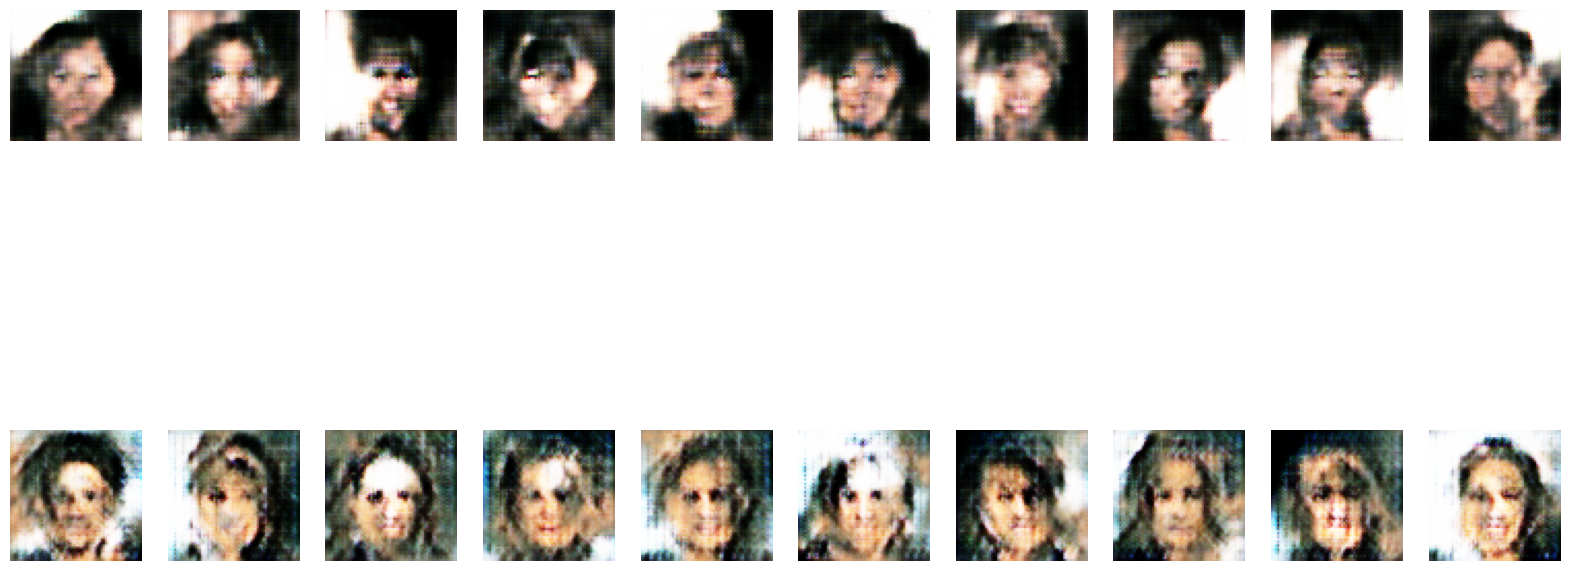

In [26]:
# 결과 확인
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import os

img_list = []
file_list = sorted(os.listdir('./celeba_gan_output'))
for img_nm in file_list : 
    file_path = './celeba_gan_output/{}'.format(img_nm) 
    img = Image.open(file_path)
    img_array = np.array(img)
    img_list.append(img_array)

n_rows = epochs
n_cols = 10
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 10))

for i in range(n_rows):
    for j in range(n_cols):
        index = i * n_cols + j
        img_print = img_list[index]
        axes[i, j].imshow(img_print)
        axes[i, j].axis('off')

plt.show()